# Detecting Time from Analog Clock Images

## Introduction

This project explores a straightforward way to detect time from images of analog clocks by applying traditional computer vision techniques. Instead of relying on deep learning, we’re using classic image processing steps to identify clock hands and determine the time based on their angles.

The process starts with preprocessing the images to enhance contrast and clarity. From there, we locate the clock's center and use line detection methods to find the hands. By calculating their orientations, we can estimate the time with reasonable accuracy. 

One advantage of this approach is that it’s both lightweight and interpretable. Traditional computer vision methods are often simpler and faster, especially for specific, well-defined tasks like this one, which involves detecting angles and positions. The project serves as a practical example of how classical computer vision can effectively solve tasks in image analysis without needing large datasets or training models.

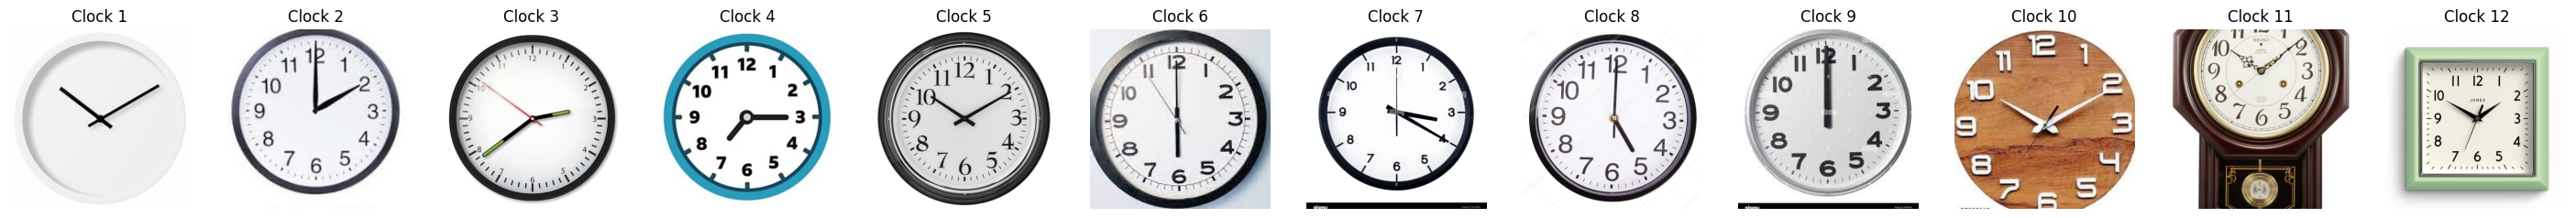

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Set target image size for resizing
IMAGE_SIZE = (640, 640)

def load_images() -> list:
    """
    Loads and crops images from a directory, selecting only those with "clock" in the filename
    and resizing them to a specified size.

    Returns:
        list: A list of cropped and resized images (as NumPy arrays) in BGR color format.
    """
    images = []
    # Loop through sorted list of files in the "images" folder
    for img_path in sorted(os.listdir("./images")):
        # Process only files with "clock" in the name and ".jpg" extension
        if "clock" in img_path and img_path.endswith(".jpg"):
            img = cv2.imread(os.path.join("./images", img_path))
            if img is not None:
                # Crop image to a square (centered)
                height, width = img.shape[:2]
                side = min(height, width)  # Use the smaller dimension for the square crop
                
                # Calculate cropping margins
                top = (height - side) // 2
                left = (width - side) // 2
                
                # Crop and resize the image
                cropped_img = img[top:top + side, left:left + side]
                resized_img = cv2.resize(cropped_img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
                images.append(resized_img)
            else:
                print(f"Image not found or failed to load: {img_path}")
    return images

def show_images(images: list) -> None:
    """
    Displays a list of images in a single row using matplotlib. Converts images from BGR to RGB 
    format for accurate color display.

    Args:
        images (list): A list of images in BGR color format (as NumPy arrays).
    """
    plt.figure(figsize=(len(images) * 3, 10))  # Set figure size based on number of images
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)  # Arrange all images in one row
        plt.title(f"Clock {i + 1}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.axis('off')  # Hide axes for clean display
    plt.show()

# Load and display sample images
images = load_images()
show_images(images)

### Preprocessing Pipeline for Clock Hand Detection

The cell below performs preprocessing on a list of images to prepare them for clock hand detection. The steps are as follows:

1. **Convert to Grayscale**  
   Each image is converted to grayscale to simplify the structure, focusing on intensity values alone and eliminating color.

2. **Noise Reduction with Median Blurring**  
   A median blur filter is applied to remove noise, which helps in making the clock hands' edges clearer.

3. **Adaptive Thresholding Based on Dominant Brightness**  
   - The mode (most frequent intensity) of each image is calculated to identify the dominant brightness.
   - A threshold is applied based on this mode:
     - For light backgrounds, a lower threshold is used.
     - For dark backgrounds, a higher threshold is applied.
   - This step binarizes the image to distinguish the clock hands from the background.

4. **Edge Detection with Canny**  
   The Canny edge detector is applied to the thresholded image, highlighting the edges of the clock hands for further processing.

Each step's output is displayed, allowing visual inspection of the preprocessing progression for each clock image.


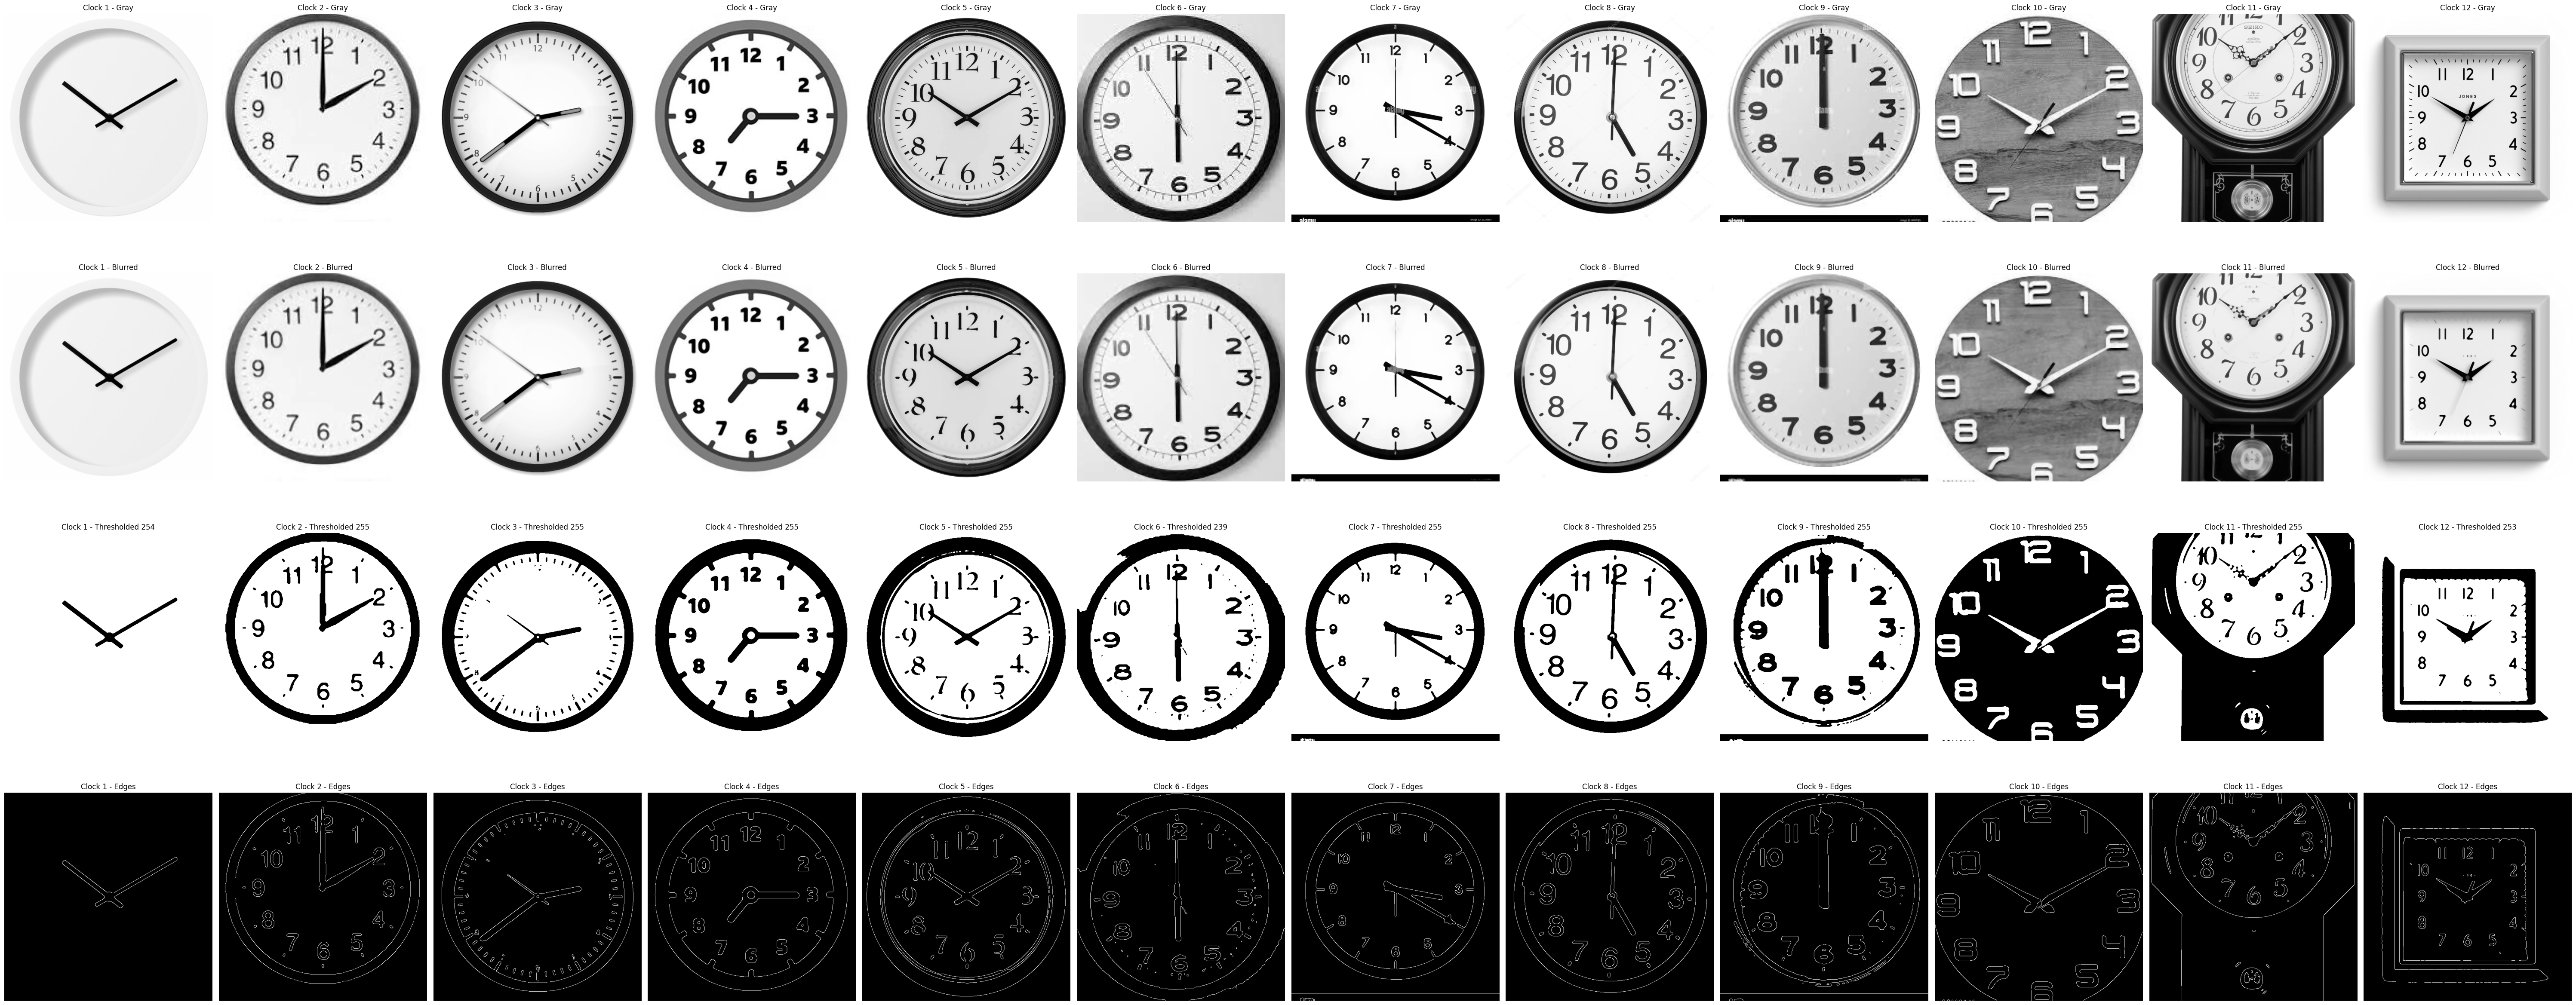

In [ ]:
from scipy import stats

def preprocessing(images: list) -> list:
    """
    Processes a list of images by converting each image to grayscale, reducing noise with a median filter, 
    applying thresholding based on the dominant brightness, and detecting edges using the Canny Edge Detector.
    The function also displays each processing step for visual inspection.

    Args:
        images (list): List of images as NumPy arrays in BGR format.

    Returns:
        list: A list of edge-detected images as NumPy arrays in grayscale.
    """
    num_images = len(images)
    image_edges = []

    # Set the plot size based on the number of images
    plt.figure(figsize=(5 * num_images, 25))

    for i, img in enumerate(images):
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Display grayscale image
        plt.subplot(4, num_images, i + 1)
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Gray")

        # Reduce noise with a median filter
        blurred = cv2.medianBlur(gray, 7)

        # Display blurred image
        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(blurred, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Blurred")

        # Calculate the dominant (modal) pixel value for thresholding
        mode_result = stats.mode(blurred.ravel())
        mode_val = mode_result.mode if mode_result.mode.size > 0 else 0  # Safe access to modal value

        # Determine threshold type based on dominant brightness
        if mode_val > 127:  # Light background
            _, thresholded = cv2.threshold(blurred, mode_val - 80, 255, cv2.THRESH_BINARY)
        else:  # Dark background
            _, thresholded = cv2.threshold(blurred, mode_val + 80, 255, cv2.THRESH_BINARY)

        # Display thresholded image
        plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(thresholded, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Thresholded {mode_val}")

        # Apply Canny Edge Detection
        edges = cv2.Canny(thresholded, threshold1=250, threshold2=350)

        # Display edge-detected image
        plt.subplot(4, num_images, 3 * num_images + i + 1)
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Edges")

        # Append edges to list for further processing
        image_edges.append(edges)

    # Adjust subplot layout for better spacing and display all images
    plt.tight_layout()
    plt.show()

    return image_edges

# Edge detection
edges = preprocessing(images)

### Circle Detection with Hough Transform for Clock Centers

The cell below detects circles in a list of edge-processed images using the Hough Circle Transform, suitable for identifying clock centers. Here’s a breakdown of the steps:

1. **Setup Detection Parameters**  
   The function uses various adjustable parameters, including:
   - `dp`: Resolution ratio for the Hough accumulator.
   - `min_dist`: Minimum allowed distance between detected circles.
   - `param1` & `param2`: Parameters for circle detection sensitivity.

2. **Filter Circles Based on Proximity to Center**  
   - The image center is calculated, and circles closer than a specified threshold are prioritized.
   - If `filter_closest` is set to `True`, only the most central circle is kept.
   - If `filter_closest` is `False`, all detected circles are retained.

3. **Visualization**  
   The results are displayed for each image, with:
   - The detected circles shown in red.
   - The circle center marked in green.

4. **Output**  
   A list of detected circles is returned, with each circle represented as a tuple of coordinates `(x, y, r)`, or as a default value if no circle is detected.

This method effectively locates the clock centers in preparation for hand detection.

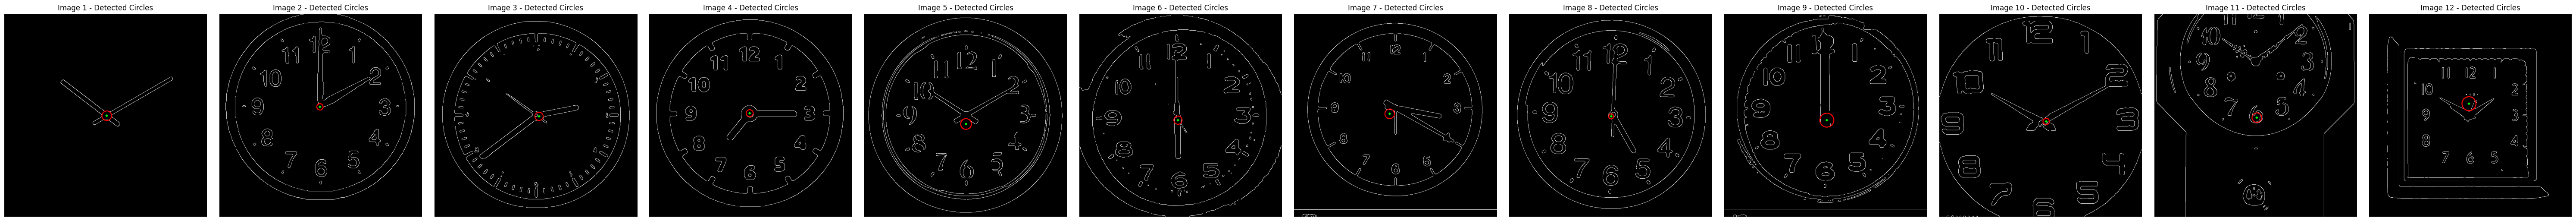

In [10]:
from typing import List, Tuple, Optional


def hough_circle_detector(edges_list: List[np.ndarray], dp: int = 2, min_dist: int = 20,
                          param1: int = 50, param2: int = 30, min_radius: int = 1, 
                          max_radius: int = 25, proximity_threshold: int = 50, 
                          filter_closest: bool = True) -> List[Tuple[int, int, int]]:
    """
    Detects circles in a list of preprocessed images with edges, using OpenCV's Hough Circle Transform.
    Optionally filters to keep only the circle closest to the center of each image.

    Args:
        edges_list (List[np.ndarray]): List of edge-processed images to perform circle detection on.
        dp (int): Inverse resolution ratio for the Hough accumulator.
        min_dist (int): Minimum distance between detected circle centers.
        param1 (int): Higher threshold for Canny edge detector.
        param2 (int): Accumulator threshold for circle detection.
        min_radius (int): Minimum radius of circles to detect.
        max_radius (int): Maximum radius of circles to detect.
        proximity_threshold (int): Maximum distance from the center of the image for a circle to be considered valid (used only if `filter_closest=True`).
        filter_closest (bool): If True, retains only the circle closest to the center for each image.

    Returns:
        List[Tuple[int, int, int]]: List containing the most central circle for each image or None if no circle was found.
    """
    circles_per_image = []  # List to store circles for each image
    num_images = len(edges_list)
    
    plt.figure(figsize=(5 * num_images, 5))  # Plot size for a single row

    for i, edges in enumerate(edges_list):
        h, w = edges.shape
        image_center = (w // 2, h // 2)  # Image center
        closest_circle = None
        min_distance = proximity_threshold  # Initialize with max threshold distance
        detected_circles = []  # To store circles for this image

        # Detect circles using the Hough Transform on the edge image
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=dp, minDist=min_dist,
                                   param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
        
        # If circles are detected, evaluate whether to apply the filter
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                x, y, r = circle
                # Calculate the Euclidean distance from the image center
                distance_to_center = np.sqrt((x - image_center[0])**2 + (y - image_center[1])**2)
                
                # If filtering is enabled, keep only the closest circle within the distance threshold
                if filter_closest:
                    if distance_to_center < min_distance:
                        closest_circle = (x, y, r)
                        min_distance = distance_to_center
                else:
                    detected_circles.append((x, y, r))  # Store all circles found
            
            if filter_closest and closest_circle:
                circles_per_image.append(closest_circle)
            elif not filter_closest:
                circles_per_image.append(detected_circles if detected_circles else (IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2, 10))

        else:
            circles_per_image.append((IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2, 10))  # No circle found
        
        # Plot the edge image with detected circles
        output_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to BGR to draw colored circles
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)

        # Draw the detected circle(s)
        if filter_closest:
            x, y, r = closest_circle
            cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)  # Red circle
            cv2.circle(output_img, (x, y), 2, (0, 255, 0), 3)  # Green center point

        elif not filter_closest and detected_circles:
            for (x, y, r) in detected_circles:
                cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)
                cv2.circle(output_img, (x, y), 2, (0, 255, 0), 3)

        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Circles")

    plt.tight_layout()
    plt.show()
    
    return circles_per_image

# Detect central blobs in the images
image_circles = hough_circle_detector(edges, filter_closest=True)

### Detecting Clock Hands with Line Detection in Edge Images

This cell detects clock hands in each preprocessed edge-detected image by identifying prominent lines, using the following steps:

1. **Set Parameters and Define Center**  
   - `radius_limit`: Radius around the center to search for lines if `restrict_to_circle` is `True`.
   - `threshold`, `line_length`, and `line_gap`: Parameters for the Hough Line Transform to control line detection sensitivity.

2. **Optional Restriction to Circular Region**  
   - If `restrict_to_circle` is `True`, the function will limit line detection to a circular area around the specified `circle_centers` for each image.
   - If no circle center is provided, it defaults to the image center.

3. **Detect and Draw Lines**  
   - Lines that fall within the specified circle (or across the whole image if `restrict_to_circle` is `False`) are added to the list of detected clock hands.
   - The detected lines are drawn on the image in green, with the restriction circle shown in red.

4. **Display Results**  
   - The processed images are displayed with the detected lines for visual inspection, each showing the lines interpreted as clock hands.

5. **Return Format**  
   - The function returns a list containing the detected hands (lines) for each image, or `None` if no lines are detected.

This method provides the clock hand positions based on prominent line features in the preprocessed images.

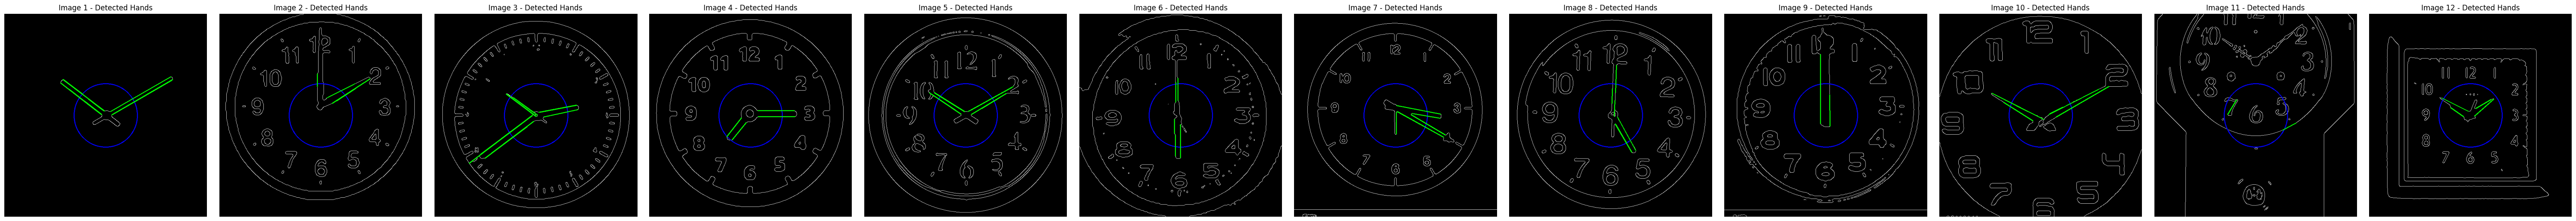

In [11]:
def detect_clock_hands(edges_list: List[np.ndarray], 
                       circle_centers: List[Optional[Tuple[int, int]]],
                       radius_limit: int = 100, 
                       threshold: int = 30, 
                       line_length: int = 50, 
                       line_gap: int = 10, 
                       restrict_to_circle: bool = True) -> List[Optional[List[Tuple[int, int, int, int]]]]:
    """
    Detects clock hands in each edge-detected image, with an option to restrict line detection within a radius around a center.

    Args:
        edges_list (List[np.ndarray]): List of edge-detected images.
        circle_centers (List[Optional[Tuple[int, int]]]): List of detected circle centers for each image.
        radius_limit (int): Maximum radius from the center to search for lines.
        threshold (int): Minimum number of intersections to detect a line.
        line_length (int): Minimum length of lines to detect.
        line_gap (int): Maximum gap between segments for line detection.
        restrict_to_circle (bool): Restrict line detection within the circle if True, else across the entire image.

    Returns:
        List[Optional[List[Tuple[int, int, int, int]]]]: List of detected hands (lines) for each image.
    """
    detected_hands_per_image = []  # List to store detected hands per image
    num_images = len(edges_list)

    plt.figure(figsize=(5 * num_images, 5))  # Plot size for display

    for i, (edges, center) in enumerate(zip(edges_list, circle_centers)):
        # Determine the center point, ensuring it has two elements
        if isinstance(center, tuple) and len(center) == 2:
            cx, cy = center
        else:
            cx, cy = edges.shape[1] // 2, edges.shape[0] // 2  # Default center

        # Convert to BGR for colored visualization
        output_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # Detect lines using Hough Line Transform
        lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=threshold,
                                minLineLength=line_length, maxLineGap=line_gap)

        # Draw a circle around the center if restricting line detection
        if restrict_to_circle:
            cv2.circle(output_img, (cx, cy), radius_limit, (0, 0, 255), 2)

        detected_lines = []
        
        if lines is not None:
            # Filter lines by their proximity to the defined circle
            for line in lines:
                x1, y1, x2, y2 = line[0]
                
                if not restrict_to_circle or (
                    np.hypot(x1 - cx, y1 - cy) <= radius_limit or 
                    np.hypot(x2 - cx, y2 - cy) <= radius_limit):
                    detected_lines.append((x1, y1, x2, y2))
                    cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw lines in green

        detected_hands_per_image.append(detected_lines if detected_lines else None)

        # Plot each processed image with detected lines
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Hands")

    plt.tight_layout()
    plt.show()

    return detected_hands_per_image

# Example usage
clock_hands = detect_clock_hands(edges, image_circles, threshold=20, restrict_to_circle=True, line_gap=10, line_length=40)

### Enhanced Clock Hand Detection with Edge Dilation and Radius Filtering

This cell detects clock hands in preprocessed edge-detected images, improving upon previous versions by enhancing edge detection and filtering based on proximity to the clock center. Here’s why this approach is more effective:

1. **Edge Dilation for Enhanced Line Detection**
   - The function dilates each edge-detected image before applying line detection. This dilation step enhances fine lines, making clock hands more pronounced and easier to detect compared to non-dilated images.
   - Dilation reduces the likelihood of missing faint clock hands that are less defined in the initial edge detection.

2. **Center-Based Filtering and Radius Limitation**
   - Similar to the previous function, this one filters detected lines based on their proximity to the center. However, it refines this filter with an adjustable `radius_limit`, giving better control over the area in which lines are detected.
   - This approach improves accuracy by ignoring irrelevant lines (such as background features) outside the clock's radius, focusing only on the most relevant lines within the clock’s area.

3. **Visual and Structural Enhancements**
   - The output includes both the dilated edge images and the detected clock hands, providing a comprehensive view of the results.
   - Each image’s center is highlighted with a red circle for visual feedback on the radius constraint. This circle indicates the search area, helping users verify the area being processed.

4. **Return Format for Downstream Processing**
   - By returning both the dilated edge images and the list of detected lines (clock hands), this function makes it easier to pass results directly into subsequent analysis or visualization steps.
   - The dual output structure also allows easy debugging and quality assessment, as users can review both the enhanced edge maps and the final detected hands.

So, this function improves the reliability and precision of clock hand detection by adding an edge dilation step, refining the radius-based line filter, and providing a richer set of outputs for analysis.

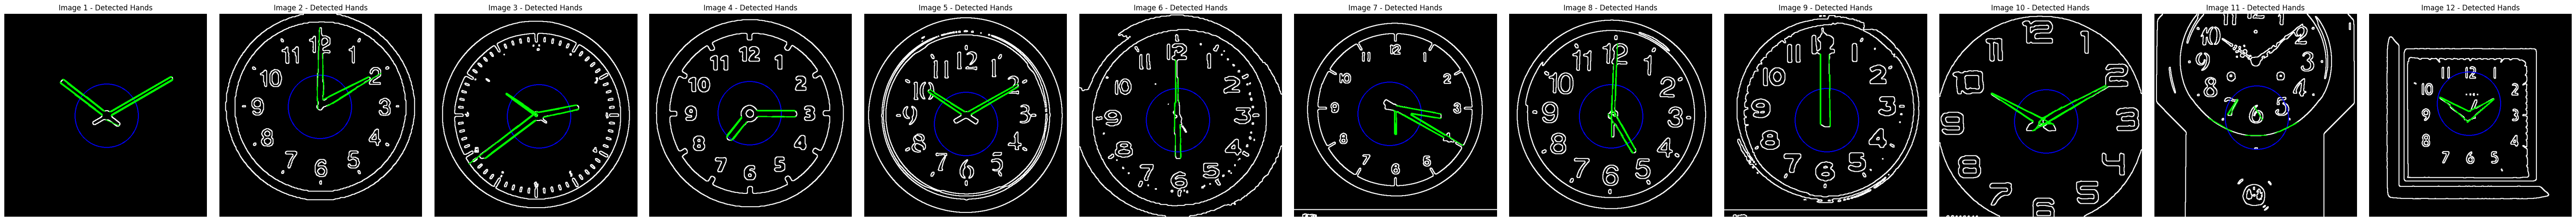

In [12]:
def detect_clock_hands(
        edges_list: List[np.ndarray],
        circle_centers: List[Optional[Tuple[int, int]]],
        radius_limit: int = 100,
        threshold: int = 20,
        line_length: int = 30,
        line_gap: int = 20,
        restrict_to_circle: bool = True
    ) -> Tuple[List[np.ndarray], List[Optional[List[Tuple[int, int, int, int]]]]]:
    """
    Detects clock hands in each edge-detected image, with an option to restrict line detection within a radius around a specified center.

    Args:
        edges_list (List[np.ndarray]): List of edge-detected images.
        circle_centers (List[Optional[Tuple[int, int]]]): List of detected circle centers (x, y) for each image.
        radius_limit (int): Radius from the center within which to search for lines.
        threshold (int): Minimum number of intersections to detect a line.
        line_length (int): Minimum line length to detect.
        line_gap (int): Maximum gap between segments to form a line.
        restrict_to_circle (bool): If True, restricts line detection to within the radius limit around the center.

    Returns:
        Tuple[List[np.ndarray], List[Optional[List[Tuple[int, int, int, int]]]]]: 
            - List of dilated edge images.
            - List of detected hands for each image (each hand represented as a line with coordinates).
    """
    num_images = len(edges_list)
    detected_hands_per_image = []
    dilated_edges = []

    plt.figure(figsize=(5 * num_images, 5))

    for i, (edges, center) in enumerate(zip(edges_list, circle_centers)):
        # Dilate edges to enhance line detection
        edges_dilated = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)
        dilated_edges.append(edges_dilated)

        # Convert to color image for visualization
        output_img = cv2.cvtColor(edges_dilated, cv2.COLOR_GRAY2BGR)

        # Set the center to the provided value (first two elements) or default to the image center
        cx, cy = (center[:2] if center is not None else (edges.shape[1] // 2, edges.shape[0] // 2))

        # Detect lines using the Hough Line Transform
        lines = cv2.HoughLinesP(
            edges_dilated, rho=1, theta=np.pi / 180, threshold=threshold,
            minLineLength=line_length, maxLineGap=line_gap
        )

        # Optionally draw a circle for visual reference
        if restrict_to_circle:
            cv2.circle(output_img, (cx, cy), radius_limit, (0, 0, 255), 2)

        # Filter lines based on proximity to the circle's radius
        detected_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                start_within_radius = np.hypot(x1 - cx, y1 - cy) <= radius_limit
                end_within_radius = np.hypot(x2 - cx, y2 - cy) <= radius_limit

                # Append the line if it meets the criteria
                if not restrict_to_circle or start_within_radius or end_within_radius:
                    detected_lines.append((x1, y1, x2, y2))
                    cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        detected_hands_per_image.append(detected_lines if detected_lines else None)

        # Plot the image with detected lines
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Hands")

    plt.tight_layout()
    plt.show()

    return dilated_edges, detected_hands_per_image

# Example usage
dilated_edges, clock_hands = detect_clock_hands(
    edges, image_circles, threshold=20, restrict_to_circle=True, line_gap=10, line_length=40
)

### Calculation and Merging of Lines in Clock Hands

In this notebook, we implement a series of functions to analyze the lines detected in images of clocks. The main operations performed include:

1. **Angle Calculation**:
   We use the `calculate_angle` function to determine the angle of a line relative to the x-axis. This function takes the coordinates of two points and returns the angle in degrees.

2. **Line Merging**:
   The `merge_lines` function takes a group of similar lines and returns a single line, which can either be the longest line or the average of the lines in the group. The length of each line is calculated to identify the longest one.

3. **Grouping and Merging Lines**:
   The `group_and_merge_lines` function handles the process of grouping and merging lines. This function:
   - Groups lines based on their angles, using an `angle_threshold` to determine similarity.
   - Merges similar lines based on the distance between them, using a `distance_threshold`.
   - Finally, it displays the merged lines on the provided images.

The final output is a list of consolidated lines for each image, ready for further analysis or visualization.

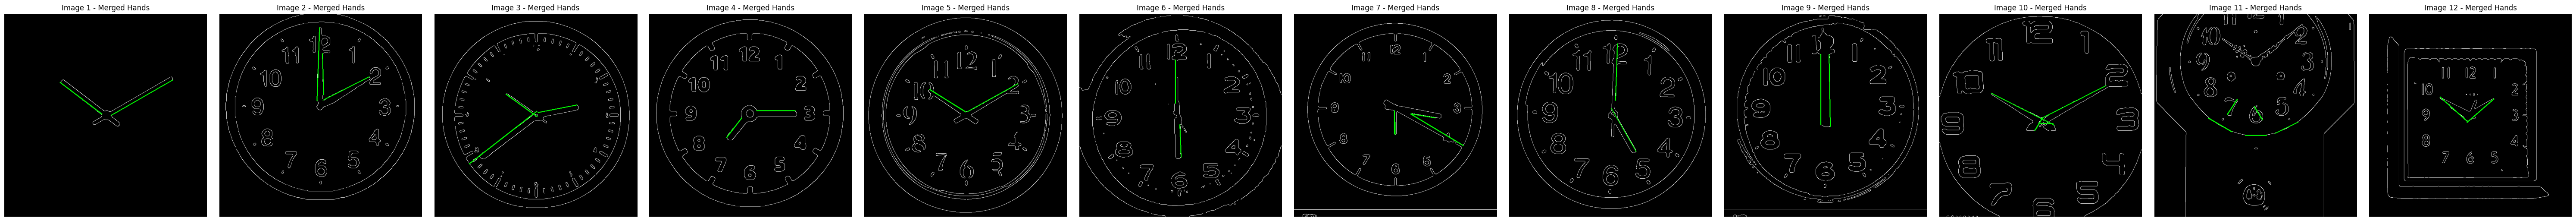

In [13]:
from math import atan2, degrees, sqrt

def calculate_angle(x1: float, y1: float, x2: float, y2: float) -> float:
    """
    Calculate the angle of a line relative to the x-axis.

    Args:
        x1 (int): x-coordinate of the first point.
        y1 (int): y-coordinate of the first point.
        x2 (int): x-coordinate of the second point.
        y2 (int): y-coordinate of the second point.

    Returns:
        float: Angle in degrees.
    """
    return degrees(atan2(y2 - y1, x2 - x1))

def merge_lines(line_group: list[tuple[int, int, int, int]]) -> tuple[int, int, int, int]:
    """
    Merge a group of similar lines into a single average line.

    This function calculates the longest line within the group and returns it,
    or alternatively returns the average of all lines' endpoints.

    Args:
        line_group (List[Tuple[int, int, int, int]]): List of lines represented by tuples (x1, y1, x2, y2).

    Returns:
        Tuple[int, int, int, int]: A tuple representing the merged line's coordinates (x1, y1, x2, y2).
    """
    # Track the longest line by length
    max_length = 0
    longest_line = None

    for (x1, y1, x2, y2) in line_group:
        # Calculate current line's length
        length = sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        # Update if this is the longest line found so far
        if length > max_length:
            max_length = length
            longest_line = (x1, y1, x2, y2)
    
    # If a longest line is identified, return it; otherwise calculate average line
    #if longest_line:
    return longest_line

    # Calculate average coordinates if no clear longest line
    x1_coords = [x1 for x1, _, _, _ in line_group]
    y1_coords = [y1 for _, y1, _, _ in line_group]
    x2_coords = [x2 for _, _, x2, _ in line_group]
    y2_coords = [y2 for _, _, _, y2 in line_group]

    return (
        int(np.mean(x1_coords)), int(np.mean(y1_coords)),
        int(np.mean(x2_coords)), int(np.mean(y2_coords))
    )

def group_and_merge_lines(
    edges_list: list[np.ndarray], 
    clock_hands: list[list[tuple[int, int, int, int]]], 
    angle_threshold: float = 10, 
    distance_threshold: float = 15
) -> list[list[tuple[int, int, int, int]]]:
    """
    Group and merge similar lines for each image in `clock_hands` based on angle and distance thresholds.

    Args:
        edges_list (List[np.ndarray]): List of edge-detected images, used for plotting.
        clock_hands (List[List[Tuple[int, int, int, int]]]): List containing lists of lines for each image, 
            where each line is a tuple (x1, y1, x2, y2).
        angle_threshold (int): Maximum angle difference to consider lines similar (in degrees).
        distance_threshold (int): Maximum distance to merge similar lines.

    Returns:
        List[List[Tuple[int, int, int, int]]]: List of consolidated lines for each image.
    """
    consolidated_lines_per_image = []

    # Plot setup for displaying results
    plt.figure(figsize=(5 * len(edges_list), 5))

    for idx, lines in enumerate(clock_hands):
        # Skip if there are no lines for the current image
        if not lines:
            consolidated_lines_per_image.append(None)
            continue

        # Step 1: Group lines based on angle similarity
        angle_groups = {}
        for line in lines:
            # Ensure each line has exactly four coordinates
            if len(line) == 4:
                x1, y1, x2, y2 = line
                angle = calculate_angle(x1, y1, x2, y2)
                found_group = False
                for group_angle in list(angle_groups):
                    if abs(angle - group_angle) < angle_threshold:
                        angle_groups[group_angle].append((x1, y1, x2, y2))
                        found_group = True
                        break
                # Create a new group if no similar angle group was found
                if not found_group:
                    angle_groups[angle] = [(x1, y1, x2, y2)]

        # Step 2: Merge lines within each angle group based on distance
        merged_lines = [merge_lines(line_group) for line_group in angle_groups.values()]

        consolidated_lines_per_image.append(merged_lines)

        # Step 3: Plotting the merged lines on each image
        output_img = cv2.cvtColor(edges_list[idx], cv2.COLOR_GRAY2BGR)
        for (x1, y1, x2, y2) in merged_lines:
            cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw merged lines in green

        plt.subplot(1, len(edges_list), idx + 1)
        plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Image {idx + 1} - Merged Hands")

    plt.tight_layout()
    plt.show()

    return consolidated_lines_per_image

# Example usage
grouped_clock_hands = group_and_merge_lines(edges, clock_hands, angle_threshold=20, distance_threshold=15)

# Clock Time Calculation and Visualization

In this section of the notebook, we implement functions to calculate the approximate time based on the positions of the clock hands in images. The main functionalities include:

1. **Angle Calculation**:
   The `calculate_angle` function determines the clockwise angle of a line from the vertical (12 o'clock) position. This function takes the coordinates of two endpoints of the line and the center of the clock, and returns the angle in degrees along with a boolean indicating whether the endpoints were swapped to ensure the farther endpoint is correctly identified.

2. **Time Calculation**:
   The `calculate_time_from_hands` function estimates the time from the clock hands' positions. It receives a list of hand coordinates and the center of the clock, determining which hand is the minute hand and which is the hour hand based on their lengths. The angles of the hands are then used to compute the time in "HH:MM" format.

3. **Visualization**:
   The `plot_clock_times` function displays the edge-detected images with the calculated time based on the positions of the clock hands. It highlights the hands with colored endpoints: red for the end closer to the center and blue for the farther end. If no hands are detected, it shows a message indicating that the time could not be detected.

The final output includes images of the clocks with the estimated time displayed in the title.

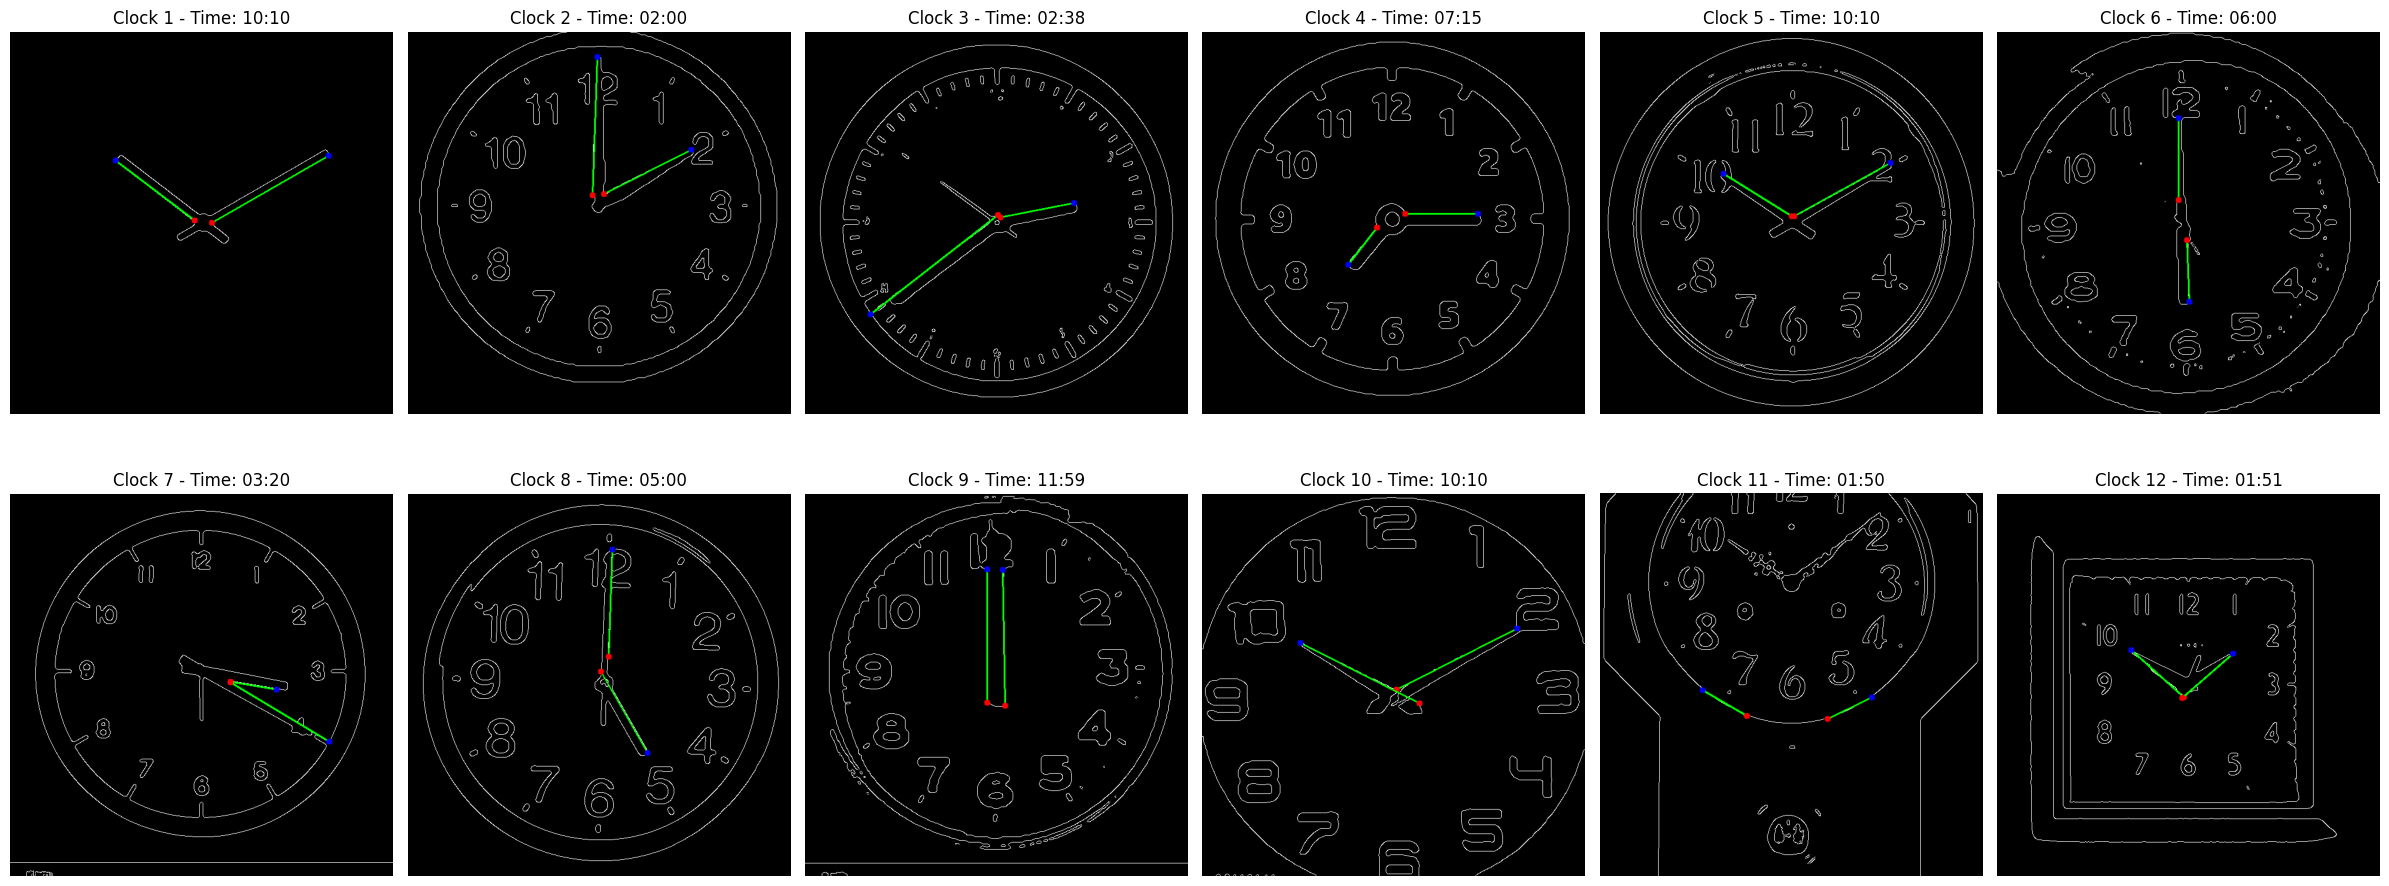

In [14]:
def calculate_angle(x1: int, y1: int, x2: int, y2: int, center: tuple[int, int]) -> tuple[float, bool]:
    """
    Calculate the clockwise angle of a line from the vertical (12 o'clock).

    Args:
        x1 (int): x-coordinate of the line's first endpoint.
        y1 (int): y-coordinate of the line's first endpoint.
        x2 (int): x-coordinate of the line's second endpoint.
        y2 (int): y-coordinate of the line's second endpoint.
        center (Tuple[int, int]): Coordinates of the clock center (x, y).

    Returns:
        Tuple[float, bool]: A tuple containing:
            - angle (float): Angle of the line in degrees.
            - swapped (bool): Whether endpoints were swapped to ensure (x2, y2) is farther from the center.
    """
    def dist(p1: tuple[int, int], p2: tuple[int, int]) -> float:
        """Calculate Euclidean distance between two points."""
        return sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # Swap endpoints if (x1, y1) is farther from the center than (x2, y2)
    swapped = False
    if dist(center, (x1, y1)) > dist(center, (x2, y2)):
        x1, y1, x2, y2 = x2, y2, x1, y1
        swapped = True

    # Calculate angle relative to vertical (12 o'clock)
    dx, dy = x2 - x1, y2 - y1
    angle = (degrees(atan2(dy, dx)) + 90) % 360  # Ensure angle is within [0, 360)

    return angle, swapped

def calculate_time_from_hands(hands: list[tuple[int, int, int, int]], center: tuple[int, int]) -> str:
    """
    Calculate the approximate time from clock hands' positions.

    Args:
        hands (List[Tuple[int, int, int, int]]): List of tuples representing clock hands ((x1, y1, x2, y2) for each hand).
        center (Tuple[int, int]): Coordinates of the clock center (x, y).

    Returns:
        str: Time string in "HH:MM" format or an error message if time can't be detected.
    """
    if len(hands) < 2:
        return "Time not detected"

    # Determine minute and hour hands based on length
    minute_hand, hour_hand = hands[0], hands[1]
    minute_length = sqrt((minute_hand[2] - minute_hand[0]) ** 2 + (minute_hand[3] - minute_hand[1]) ** 2)
    hour_length = sqrt((hour_hand[2] - hour_hand[0]) ** 2 + (hour_hand[3] - hour_hand[1]) ** 2)

    if minute_length < hour_length:
        minute_hand, hour_hand = hour_hand, minute_hand

    # Calculate angles of hands
    minute_angle, _ = calculate_angle(*minute_hand, center)
    hour_angle, _ = calculate_angle(*hour_hand, center)

    # Compute approximate time from angles
    minutes = int((minute_angle / 6) % 60)
    hours = (hour_angle / 30) % 12 or 12

    # Adjust hours for minute proximity to next or previous hour
    if (hours % 1) > 0.5 and minutes < 15:
        hours = int(hours + 1) if hours + 1 <= 12 else 1
    elif (hours % 1) < 0.5 and minutes > 45:
        hours = int(hours - 1) if hours - 1 >= 1 else 12

    return f"{int(hours):02}:{minutes:02}"

def plot_clock_times(
    edges_list: list[np.ndarray],
    grouped_clock_hands: list[list[tuple[int, int, int, int]]],
    centers: list[tuple[int, int]]
):
    """
    Plot images with the calculated time based on clock hands. Highlights hands with colored endpoints.

    Args:
        edges_list (List[np.ndarray]): List of original edge-detected images.
        grouped_clock_hands (List[List[Tuple[int, int, int, int]]]): List of consolidated clock hands for each image.
        centers (List[Tuple[int, int]]): List of clock center points for each image.
    """
    n_images = len(edges_list)
    n_cols = 6  # Number of columns per row
    n_rows = (n_images + n_cols - 1) // n_cols  # Calculate the number of rows needed

    plt.figure(figsize=(24, 5 * n_rows))

    for idx, (img, hands) in enumerate(zip(edges_list, grouped_clock_hands)):
        center = centers[idx]

        # Determine the time based on hands' position or set "Time not detected" if no hands
        if hands is None or len(hands) == 0:
            time_string = "Time not detected"
        else:
            # Sort hands by length, keeping the two longest
            hands = sorted(hands, key=lambda h: sqrt((h[2] - h[0]) ** 2 + (h[3] - h[1]) ** 2), reverse=True)[:2]
            time_string = calculate_time_from_hands(hands, center)

        output_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for (x1, y1, x2, y2) in hands:
            _, swapped = calculate_angle(x1, y1, x2, y2, center)

            # Draw clock hand
            cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Draw endpoints, red for closer to center, blue for farther
            if swapped:
                cv2.circle(output_img, (x1, y1), 5, (0, 0, 255), -1)  # Far end (blue)
                cv2.circle(output_img, (x2, y2), 5, (255, 0, 0), -1)  # Near end (red)
            else:
                cv2.circle(output_img, (x1, y1), 5, (255, 0, 0), -1)  # Near end (red)
                cv2.circle(output_img, (x2, y2), 5, (0, 0, 255), -1)  # Far end (blue)

        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Clock {idx + 1} - Time: {time_string}")

    plt.tight_layout()
    plt.show()


# Esempio di utilizzo
plot_clock_times(edges, grouped_clock_hands, image_circles)

## Final Considerations

This project, completed by Lorenzo Arcioni as part of a Computer Vision Challenge, demonstrates the effectiveness of traditional computer vision techniques in solving the task of detecting time from analog clock images. By leveraging methods such as image preprocessing, line detection, and angle calculation, we achieve reasonable accuracy in time estimation without the complexity associated with deep learning approaches. 

### Strengths
- **Simplicity**: The implementation is straightforward and easy to understand, making it accessible for those new to computer vision.
- **Speed**: Classical image processing techniques are generally faster than deep learning methods, particularly for specific tasks, allowing for real-time applications in detecting clock times.
- **Resource Efficiency**: This approach does not require large datasets for training or extensive computational resources, making it suitable for scenarios where resources are limited.

### Weaknesses
- **Robustness**: The method may falter under challenging conditions, such as poor image quality, significant occlusions, or varying lighting conditions. The algorithm's reliance on clear and distinct clock features makes it less adaptable to non-standard designs.
- **Precision**: While the method is effective for standard analog clocks, it might struggle with artistic or abstract representations where hands are not clearly defined.

### Future Improvements
To enhance the robustness and versatility of this approach, future work could incorporate machine learning techniques. Training a model to recognize clock hands in various styles and conditions could significantly improve detection accuracy. Additionally, implementing more advanced image processing techniques, such as adaptive thresholding or contour detection, may help mitigate issues arising from shadows and reflections.

Overall, this project serves as a practical example of how traditional computer vision can provide reliable solutions for specific tasks, paving the way for future advancements in time detection from analog clocks. 

**Author**: *Lorenzo Arcioni*

**Event**: Computer Vision Short-Challenge

**Date**: November 2024